In [1]:
import tensorflow as tf;
import numpy as np;
import matplotlib.pyplot as plt;
print(tf.__version__);
import pandas as pd;

from sklearn.metrics import mean_squared_error;

2.3.0


In [2]:
from constants import *;
from NN_predict_v1 import *;

In [3]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

[]

### The goal of this file:
Try to set up the environment so that all the zip codes are fed into the data

#### Reading the zri csv file

In [4]:
multi_data = pd.read_csv('../data/zri_multifamily_v2.csv');
# multi_data = multi_data[multi_data["State"] == "NY"];
multi_data.head()

zip      City State        Metro      CountyName year-month    zri
0  1013  Chicopee    MA  Springfield  Hampden County    2014-01  928.0
1  1013  Chicopee    MA  Springfield  Hampden County    2014-02  931.0
2  1013  Chicopee    MA  Springfield  Hampden County    2014-03  934.0
3  1013  Chicopee    MA  Springfield  Hampden County    2014-04  929.0
4  1013  Chicopee    MA  Springfield  Hampden County    2014-05  929.0

In [5]:
# df = multi_data[multi_data["year-month"]=="2014-01"];
# temp = df.groupby("State")["zip"].count();
# temp = pd.DataFrame({"State": temp.index, "num_zip": temp});
# temp.reset_index(drop = True, inplace = True);

In [6]:
# temp.sort_values("num_zip", ascending = False, inplace = True);
# print(df[df["State"].isin(zone_dict["zone_6"])].shape[0])

zone_dict = {
    "zone_1": ["MA", "CT", "RI", "DC", "NJ", "ME", "NH"],
    "zone_2": ["NY"],
    "zone_3": ["FL", "GA", "NC", "TN", "SC", "KY", "MO", "AR"],
    "zone_4": ["CA", "WA", "OR", "AK", "HI"],
    "zone_5": ["TX", "CO", "AZ", "KS", "UT", "NV", "MT", "OK", "ND", "NM"],
    "zone_6": ["IL", "PA", "VA", "OH", "WI", "MD", "MN", "IN", "MI", "WV", "IA"]
};

In [7]:
# In our first try, just look at the zip codes in NY.
multi_3 = multi_data[multi_data["State"].isin(zone_dict["zone_3"])]["zip"].unique();
print(len(multi_3))

202


#### Segmenting the csv file into tens of thousands of windows

In [8]:
@tf.autograph.experimental.do_not_convert
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [9]:
# test_NY = multi_data[multi_data["zip"] == 10001];

# single_city_series = np.array(test_NY["zri"])

In [10]:
cities_stats = {};
dataset = windowed_dataset(np.zeros(1), WINDOW_SIZE, BATCH_SIZE, 60);
validset = windowed_dataset(np.zeros(1), WINDOW_SIZE, BATCH_SIZE, 60);

dataset_created = False;
#for zip_num in multi_data["zip"].unique():
for zip_num in multi_3:
    test = multi_data[multi_data["zip"] == zip_num];
    single_city_series = np.array(test["zri"]);
    
    single_city_series_mean = single_city_series.mean();
    single_city_series_std = single_city_series.std();
    single_city_series = (single_city_series - single_city_series_mean)/\
    single_city_series_std;
    
    cities_stats[zip_num] = {"mean": single_city_series_mean,
                             "std":single_city_series_std};
    
    single_city_train = single_city_series[:SPLIT];
    single_city_test = single_city_series[SPLIT-WINDOW_SIZE:];
    
    cityset = windowed_dataset(single_city_train, WINDOW_SIZE, BATCH_SIZE, 60);
    cityvalid = windowed_dataset(single_city_test, WINDOW_SIZE, BATCH_SIZE, 60);
    
    dataset = dataset.concatenate(cityset);
    validset = validset.concatenate(cityvalid);

In [11]:
# i = 0
# for x,y in dataset:
#     print("x = ", x.numpy())
#     print("y = ", y.numpy())
# i

In [12]:
# Concatenate tensorflow dataset
# cities_stats

#### Messing up with the Tensorflow models

In [13]:
tf.keras.backend.clear_session()
# dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
#     tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=[None]),
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
    #  tf.keras.layers.SimpleRNN(16, return_sequences=True),
    #  tf.keras.layers.SimpleRNN(16, return_sequences=True),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
#   tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 2.0)
])

model.summary();

# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="./tensorflow_ckpt/{epoch:03d}_{mse:.4f}_{val_mse:.4f}",\
#                                                  save_best_only=False,\
#                                                  save_weights_only=False, verbose=1,\
#                                                  save_freq="epoch");

optimizer = tf.keras.optimizers.SGD(learning_rate=3e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer="adam",
              metrics=["mae", "mse"])
# history = model.fit(dataset, epochs=10, validation_data=validset,\
#                     callbacks=[cp_callback])
with tf.device(tf.DeviceSpec(device_type="CPU", device_index=0)):
    history = model.fit(dataset, epochs=500, validation_data=validset);

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 18,017
Trainable params: 18,017
Non-trainable params: 0
____________________________________________________

Epoch 43/500
404/404 [==============================] - 15s 37ms/step - loss: 0.0084 - mae: 0.0891 - mse: 0.0168 - val_loss: 0.0212 - val_mae: 0.1497 - val_mse: 0.0425
Epoch 44/500
404/404 [==============================] - 15s 36ms/step - loss: 0.0084 - mae: 0.0890 - mse: 0.0168 - val_loss: 0.0204 - val_mae: 0.1446 - val_mse: 0.0410
Epoch 45/500
404/404 [==============================] - 15s 36ms/step - loss: 0.0084 - mae: 0.0890 - mse: 0.0168 - val_loss: 0.0201 - val_mae: 0.1423 - val_mse: 0.0404
Epoch 46/500
404/404 [==============================] - 15s 38ms/step - loss: 0.0083 - mae: 0.0886 - mse: 0.0167 - val_loss: 0.0212 - val_mae: 0.1491 - val_mse: 0.0426
Epoch 47/500
404/404 [==============================] - 15s 38ms/step - loss: 0.0084 - mae: 0.0890 - mse: 0.0167 - val_loss: 0.0206 - val_mae: 0.1454 - val_mse: 0.0414
Epoch 48/500
404/404 [==============================] - 15s 38ms/step - loss: 0.0084 - mae: 0.0887 - mse: 0.0167 - val_loss: 0.0218 - val_mae: 0.1520 - val_mse:

Epoch 92/500
404/404 [==============================] - 15s 36ms/step - loss: 0.0079 - mae: 0.0871 - mse: 0.0158 - val_loss: 0.0216 - val_mae: 0.1483 - val_mse: 0.0433
Epoch 93/500
404/404 [==============================] - 14s 35ms/step - loss: 0.0079 - mae: 0.0871 - mse: 0.0158 - val_loss: 0.0223 - val_mae: 0.1523 - val_mse: 0.0447
Epoch 94/500
404/404 [==============================] - 14s 35ms/step - loss: 0.0079 - mae: 0.0871 - mse: 0.0158 - val_loss: 0.0231 - val_mae: 0.1573 - val_mse: 0.0464
Epoch 95/500
404/404 [==============================] - 14s 36ms/step - loss: 0.0079 - mae: 0.0872 - mse: 0.0158 - val_loss: 0.0241 - val_mae: 0.1627 - val_mse: 0.0483
Epoch 96/500
404/404 [==============================] - 14s 34ms/step - loss: 0.0079 - mae: 0.0871 - mse: 0.0158 - val_loss: 0.0225 - val_mae: 0.1533 - val_mse: 0.0452
Epoch 97/500
404/404 [==============================] - 15s 36ms/step - loss: 0.0078 - mae: 0.0870 - mse: 0.0157 - val_loss: 0.0238 - val_mae: 0.1607 - val_mse:

404/404 [==============================] - 15s 37ms/step - loss: 0.0067 - mae: 0.0822 - mse: 0.0134 - val_loss: 0.0235 - val_mae: 0.1509 - val_mse: 0.0473
Epoch 141/500
404/404 [==============================] - 15s 38ms/step - loss: 0.0066 - mae: 0.0819 - mse: 0.0133 - val_loss: 0.0246 - val_mae: 0.1589 - val_mse: 0.0493
Epoch 142/500
404/404 [==============================] - 15s 38ms/step - loss: 0.0066 - mae: 0.0818 - mse: 0.0132 - val_loss: 0.0251 - val_mae: 0.1614 - val_mse: 0.0505
Epoch 143/500
404/404 [==============================] - 15s 38ms/step - loss: 0.0067 - mae: 0.0822 - mse: 0.0134 - val_loss: 0.0236 - val_mae: 0.1527 - val_mse: 0.0473
Epoch 144/500
404/404 [==============================] - 15s 37ms/step - loss: 0.0065 - mae: 0.0814 - mse: 0.0130 - val_loss: 0.0248 - val_mae: 0.1593 - val_mse: 0.0499
Epoch 145/500
404/404 [==============================] - 15s 36ms/step - loss: 0.0066 - mae: 0.0818 - mse: 0.0131 - val_loss: 0.0241 - val_mae: 0.1549 - val_mse: 0.0484


404/404 [==============================] - 15s 37ms/step - loss: 0.0050 - mae: 0.0734 - mse: 0.0101 - val_loss: 0.0229 - val_mae: 0.1367 - val_mse: 0.0463
Epoch 189/500
404/404 [==============================] - 15s 37ms/step - loss: 0.0049 - mae: 0.0729 - mse: 0.0099 - val_loss: 0.0229 - val_mae: 0.1371 - val_mse: 0.0462
Epoch 190/500
404/404 [==============================] - 14s 35ms/step - loss: 0.0050 - mae: 0.0734 - mse: 0.0100 - val_loss: 0.0235 - val_mae: 0.1372 - val_mse: 0.0475
Epoch 191/500
404/404 [==============================] - 15s 36ms/step - loss: 0.0049 - mae: 0.0726 - mse: 0.0098 - val_loss: 0.0238 - val_mae: 0.1420 - val_mse: 0.0481
Epoch 192/500
404/404 [==============================] - 16s 40ms/step - loss: 0.0049 - mae: 0.0728 - mse: 0.0099 - val_loss: 0.0231 - val_mae: 0.1372 - val_mse: 0.0466
Epoch 193/500
404/404 [==============================] - 16s 39ms/step - loss: 0.0049 - mae: 0.0731 - mse: 0.0099 - val_loss: 0.0238 - val_mae: 0.1435 - val_mse: 0.0481


404/404 [==============================] - 14s 36ms/step - loss: 0.0040 - mae: 0.0665 - mse: 0.0079 - val_loss: 0.0237 - val_mae: 0.1455 - val_mse: 0.0478
Epoch 237/500
404/404 [==============================] - 14s 35ms/step - loss: 0.0039 - mae: 0.0655 - mse: 0.0077 - val_loss: 0.0230 - val_mae: 0.1417 - val_mse: 0.0463
Epoch 238/500
404/404 [==============================] - 15s 37ms/step - loss: 0.0038 - mae: 0.0646 - mse: 0.0075 - val_loss: 0.0234 - val_mae: 0.1436 - val_mse: 0.0471
Epoch 239/500
404/404 [==============================] - 14s 35ms/step - loss: 0.0037 - mae: 0.0643 - mse: 0.0075 - val_loss: 0.0236 - val_mae: 0.1451 - val_mse: 0.0475
Epoch 240/500
404/404 [==============================] - 13s 33ms/step - loss: 0.0037 - mae: 0.0638 - mse: 0.0074 - val_loss: 0.0244 - val_mae: 0.1483 - val_mse: 0.0491
Epoch 241/500
404/404 [==============================] - 14s 34ms/step - loss: 0.0037 - mae: 0.0645 - mse: 0.0075 - val_loss: 0.0230 - val_mae: 0.1412 - val_mse: 0.0464


404/404 [==============================] - 15s 37ms/step - loss: 0.0031 - mae: 0.0591 - mse: 0.0061 - val_loss: 0.0253 - val_mae: 0.1504 - val_mse: 0.0510
Epoch 285/500
404/404 [==============================] - 15s 36ms/step - loss: 0.0031 - mae: 0.0595 - mse: 0.0063 - val_loss: 0.0262 - val_mae: 0.1575 - val_mse: 0.0526
Epoch 286/500
404/404 [==============================] - 15s 36ms/step - loss: 0.0031 - mae: 0.0591 - mse: 0.0062 - val_loss: 0.0257 - val_mae: 0.1544 - val_mse: 0.0516
Epoch 287/500
404/404 [==============================] - 15s 37ms/step - loss: 0.0030 - mae: 0.0580 - mse: 0.0060 - val_loss: 0.0260 - val_mae: 0.1530 - val_mse: 0.0523
Epoch 288/500
404/404 [==============================] - 16s 40ms/step - loss: 0.0030 - mae: 0.0583 - mse: 0.0060 - val_loss: 0.0259 - val_mae: 0.1513 - val_mse: 0.0520
Epoch 289/500
404/404 [==============================] - 14s 35ms/step - loss: 0.0030 - mae: 0.0588 - mse: 0.0061 - val_loss: 0.0258 - val_mae: 0.1503 - val_mse: 0.0519


404/404 [==============================] - 15s 38ms/step - loss: 0.0026 - mae: 0.0549 - mse: 0.0052 - val_loss: 0.0247 - val_mae: 0.1487 - val_mse: 0.0496
Epoch 333/500
404/404 [==============================] - 16s 41ms/step - loss: 0.0024 - mae: 0.0527 - mse: 0.0049 - val_loss: 0.0254 - val_mae: 0.1519 - val_mse: 0.0509
Epoch 334/500
404/404 [==============================] - 16s 40ms/step - loss: 0.0024 - mae: 0.0519 - mse: 0.0048 - val_loss: 0.0248 - val_mae: 0.1498 - val_mse: 0.0497
Epoch 335/500
404/404 [==============================] - 15s 36ms/step - loss: 0.0024 - mae: 0.0518 - mse: 0.0047 - val_loss: 0.0248 - val_mae: 0.1486 - val_mse: 0.0497
Epoch 336/500
404/404 [==============================] - 14s 35ms/step - loss: 0.0023 - mae: 0.0512 - mse: 0.0046 - val_loss: 0.0257 - val_mae: 0.1527 - val_mse: 0.0515
Epoch 337/500
404/404 [==============================] - 15s 37ms/step - loss: 0.0023 - mae: 0.0514 - mse: 0.0046 - val_loss: 0.0251 - val_mae: 0.1508 - val_mse: 0.0503


404/404 [==============================] - 14s 36ms/step - loss: 0.0021 - mae: 0.0498 - mse: 0.0043 - val_loss: 0.0277 - val_mae: 0.1661 - val_mse: 0.0556
Epoch 381/500
404/404 [==============================] - 15s 38ms/step - loss: 0.0021 - mae: 0.0492 - mse: 0.0042 - val_loss: 0.0263 - val_mae: 0.1574 - val_mse: 0.0527
Epoch 382/500
404/404 [==============================] - 15s 38ms/step - loss: 0.0021 - mae: 0.0490 - mse: 0.0042 - val_loss: 0.0268 - val_mae: 0.1603 - val_mse: 0.0538
Epoch 383/500
404/404 [==============================] - 16s 39ms/step - loss: 0.0020 - mae: 0.0485 - mse: 0.0041 - val_loss: 0.0262 - val_mae: 0.1602 - val_mse: 0.0527
Epoch 384/500
404/404 [==============================] - 15s 36ms/step - loss: 0.0021 - mae: 0.0489 - mse: 0.0041 - val_loss: 0.0258 - val_mae: 0.1555 - val_mse: 0.0518
Epoch 385/500
404/404 [==============================] - 15s 37ms/step - loss: 0.0020 - mae: 0.0485 - mse: 0.0041 - val_loss: 0.0256 - val_mae: 0.1544 - val_mse: 0.0513


404/404 [==============================] - 15s 37ms/step - loss: 0.0018 - mae: 0.0457 - mse: 0.0036 - val_loss: 0.0290 - val_mae: 0.1730 - val_mse: 0.0582
Epoch 429/500
404/404 [==============================] - 14s 35ms/step - loss: 0.0018 - mae: 0.0448 - mse: 0.0035 - val_loss: 0.0271 - val_mae: 0.1647 - val_mse: 0.0544
Epoch 430/500
404/404 [==============================] - 14s 35ms/step - loss: 0.0018 - mae: 0.0450 - mse: 0.0035 - val_loss: 0.0277 - val_mae: 0.1662 - val_mse: 0.0557
Epoch 431/500
404/404 [==============================] - 15s 36ms/step - loss: 0.0017 - mae: 0.0444 - mse: 0.0034 - val_loss: 0.0290 - val_mae: 0.1728 - val_mse: 0.0582
Epoch 432/500
404/404 [==============================] - 15s 37ms/step - loss: 0.0017 - mae: 0.0448 - mse: 0.0035 - val_loss: 0.0293 - val_mae: 0.1741 - val_mse: 0.0588
Epoch 433/500
404/404 [==============================] - 15s 37ms/step - loss: 0.0018 - mae: 0.0451 - mse: 0.0035 - val_loss: 0.0277 - val_mae: 0.1667 - val_mse: 0.0556


404/404 [==============================] - 14s 33ms/step - loss: 0.0015 - mae: 0.0419 - mse: 0.0031 - val_loss: 0.0281 - val_mae: 0.1662 - val_mse: 0.0563
Epoch 477/500
404/404 [==============================] - 14s 35ms/step - loss: 0.0016 - mae: 0.0424 - mse: 0.0031 - val_loss: 0.0283 - val_mae: 0.1679 - val_mse: 0.0568
Epoch 478/500
404/404 [==============================] - 14s 34ms/step - loss: 0.0016 - mae: 0.0434 - mse: 0.0033 - val_loss: 0.0276 - val_mae: 0.1635 - val_mse: 0.0555
Epoch 479/500
404/404 [==============================] - 13s 32ms/step - loss: 0.0016 - mae: 0.0424 - mse: 0.0031 - val_loss: 0.0271 - val_mae: 0.1612 - val_mse: 0.0545
Epoch 480/500
404/404 [==============================] - 14s 34ms/step - loss: 0.0015 - mae: 0.0421 - mse: 0.0031 - val_loss: 0.0275 - val_mae: 0.1625 - val_mse: 0.0553
Epoch 481/500
404/404 [==============================] - 14s 35ms/step - loss: 0.0016 - mae: 0.0435 - mse: 0.0032 - val_loss: 0.0275 - val_mae: 0.1636 - val_mse: 0.0553


#### Prediction, checking results

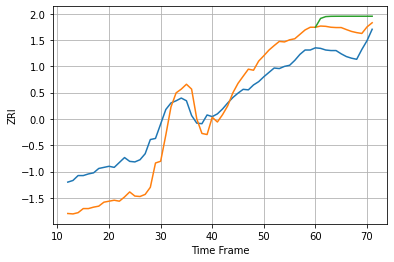

27513 48.22386565576871 40.58671471171733 61.01003281233931


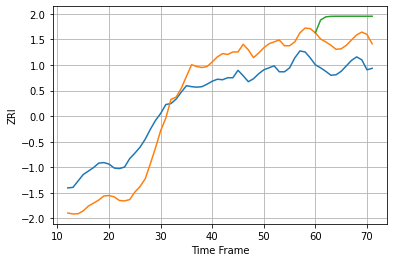

27560 54.36594716425731 54.32895706292354 100.32550337618683


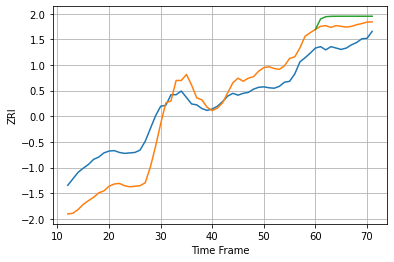

27606 52.96330701225636 41.61261832885977 59.227674944750255


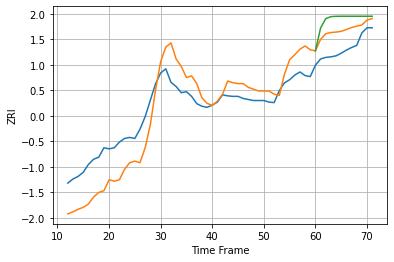

27609 46.409957626584514 35.94030758066151 57.56012930078563


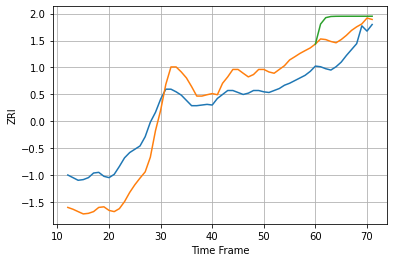

27612 39.47798684362363 31.727495795993683 55.70812733781249


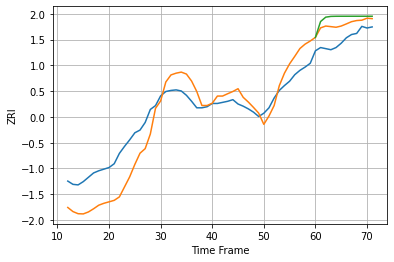

27613 40.92870954052071 29.335861310701844 41.579341075253566


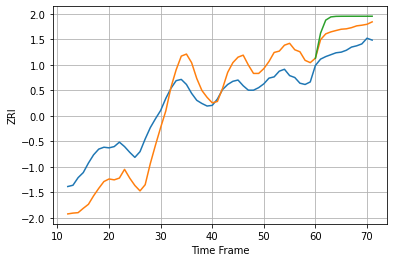

27615 41.80757609105456 30.88851479763597 47.55364397127646


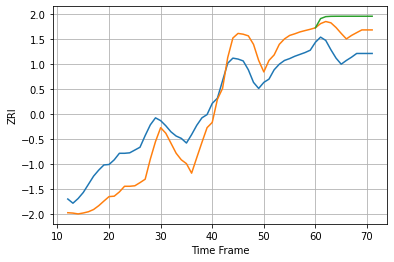

27703 55.29836407207795 49.47260063615995 76.94818793038826


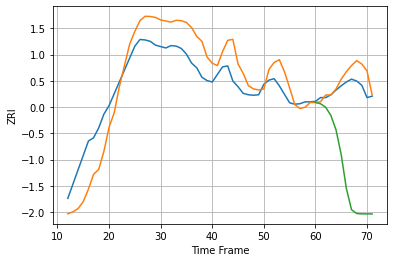

27705 52.46891441900654 26.94772587654016 190.04976108589162


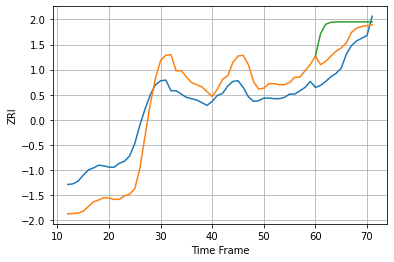

27707 37.62123045108166 27.171814439788587 56.8403607865224


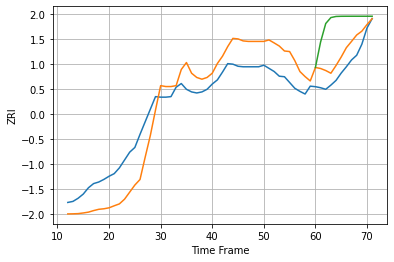

27713 47.04307969116907 30.264487051590656 88.1200132520492


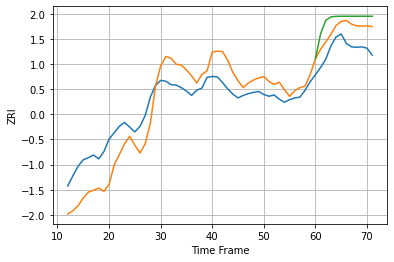

28202 54.119040264285864 45.405240199446744 69.19254694646969


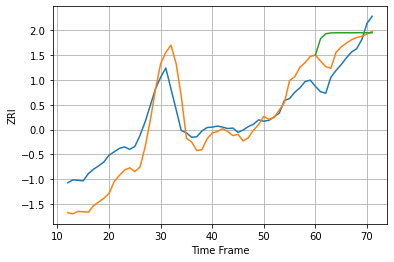

28210 46.753456648785956 38.62886066810078 69.05168925118817


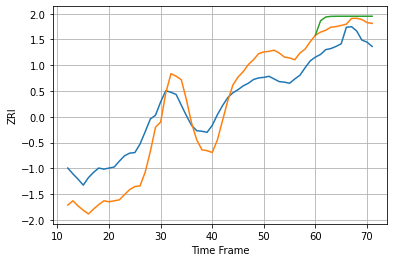

28216 48.906142021617946 34.715788017311574 48.342644819114234


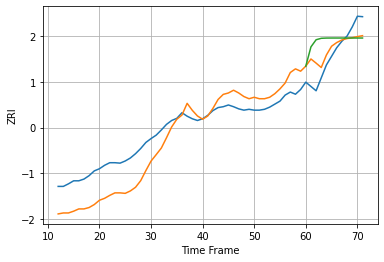

28262 49.979754614439116 36.748005224845606 60.6923431009611


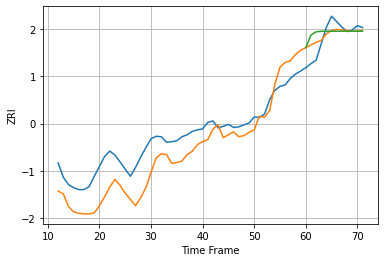

28269 46.048720314979406 22.153955204007765 29.617574932261906


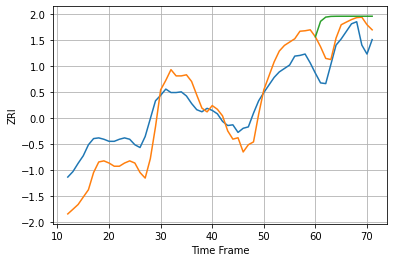

28273 34.6352813574452 30.85176668747667 53.64415072143884


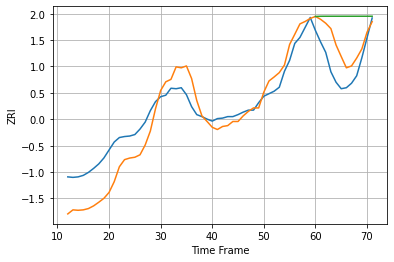

28277 43.545650336865336 48.44057362866908 100.73795093317705


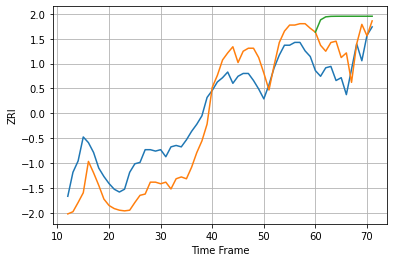

29205 19.814643852208118 18.861443632879546 35.320141904125755


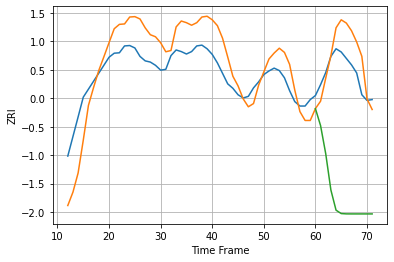

29403 65.61424307490738 59.44004080977689 307.64832952178585


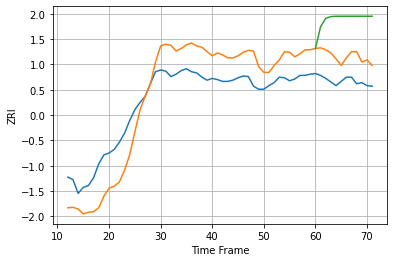

29414 44.123299681141894 41.79390580935838 102.8896341689578


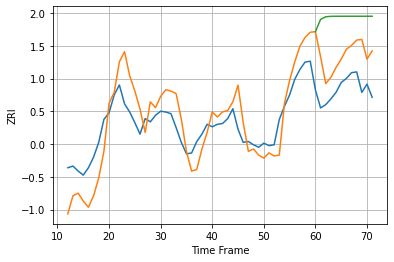

29464 29.479624361878862 44.96132283469949 88.48959227152586


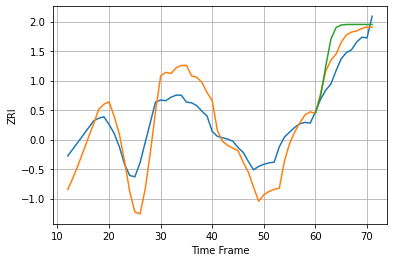

29607 34.04422339390579 20.974004633710326 36.38313378788672


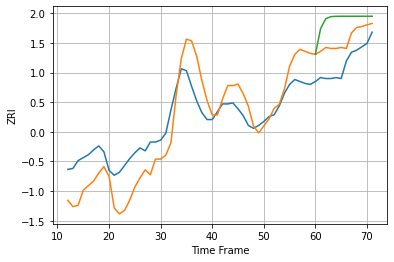

29615 27.06508103172976 24.70611323096064 46.28916229314408


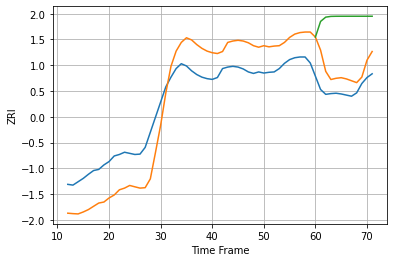

30024 78.22378595056877 58.55517972491449 189.49821736361343


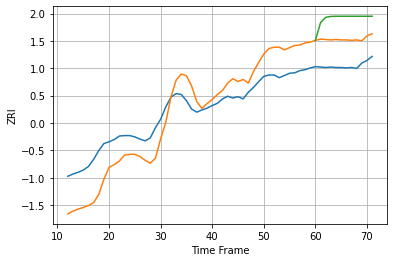

30043 55.49553060850844 60.16345481708279 106.88949538495051


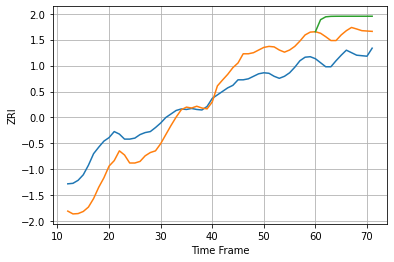

30044 47.1061438649432 48.92620557462695 79.78213455984245


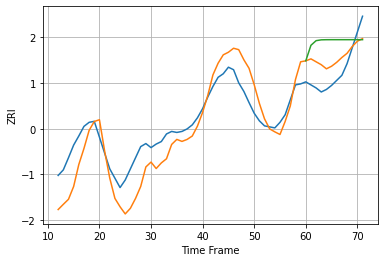

30046 44.14525235660332 39.047763254876294 71.52686648604274


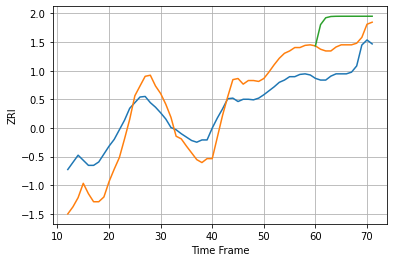

30080 43.47985553521726 45.506637862448954 87.4293014983536


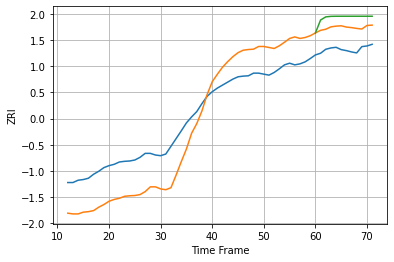

30093 87.4089475983786 65.82615116901698 95.82270480003643


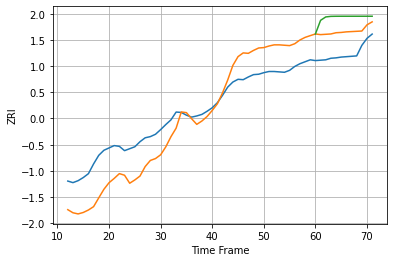

30096 65.35219116592968 58.349268388960915 92.93311447391913


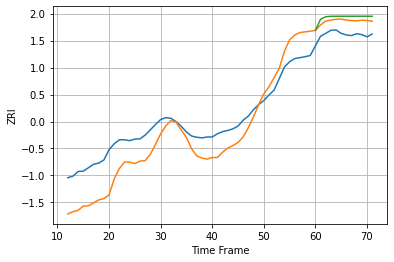

30097 76.04753291068053 43.420783000702926 55.57901412037729


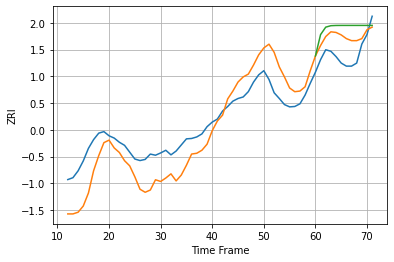

30305 63.602778714483755 50.705778412973004 74.63891779254178


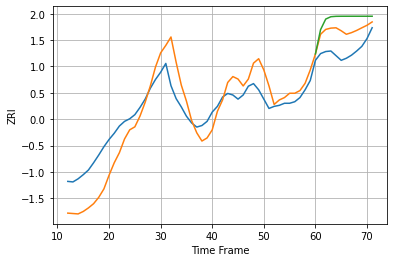

30306 44.22925243296422 39.99625842244946 62.028350582250596


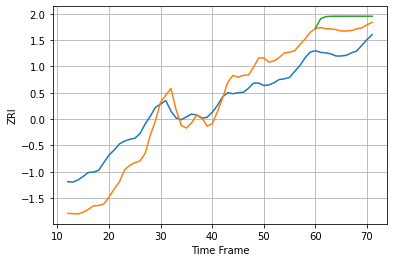

30308 66.77442496472038 62.20803094354459 93.53064680514854


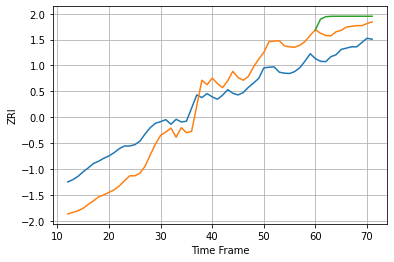

30309 76.47342163261239 66.44779555097254 101.58698340429665


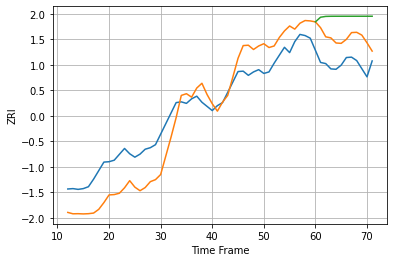

30310 66.60766687442344 72.18877086370436 124.77865582773934


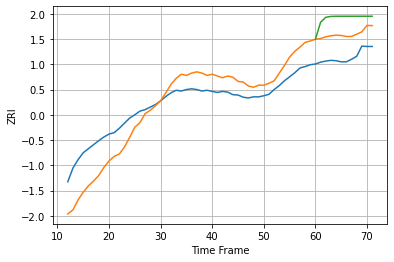

30318 57.3662866220806 63.50478932051171 107.15858399539589


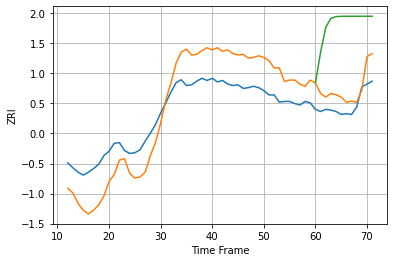

30319 39.315369882796894 24.93183422922551 112.4112328879822


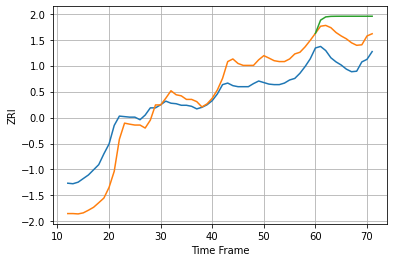

30324 43.505498818109196 48.28678361305103 83.53322846133953


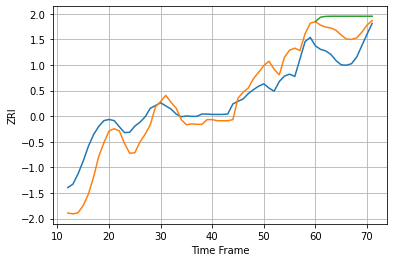

30326 49.95642064548346 58.52870570427328 94.78394255493698


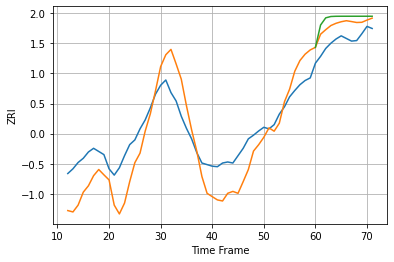

30328 52.10158940165406 30.83147401364346 42.702003104223664


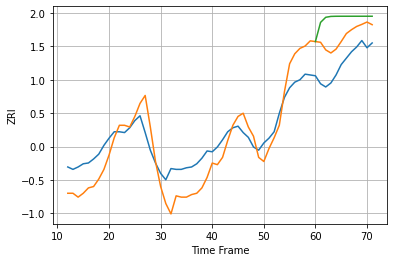

30329 27.373122454017242 34.48347667645047 58.473004133628194


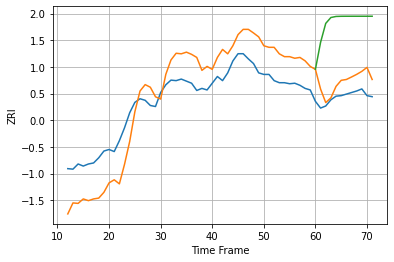

30338 54.30821716796216 34.6760870741787 144.45195098782582


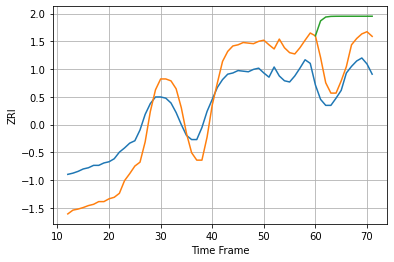

30339 47.11293294033981 45.665646539459374 109.32689449036353


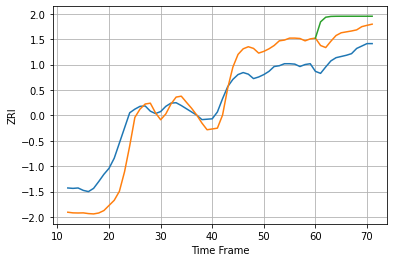

30341 56.507568543938945 56.48783035418765 96.02047599301198


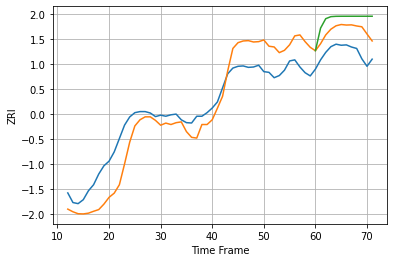

30345 63.19917857596596 61.46340712259129 95.62890072239395


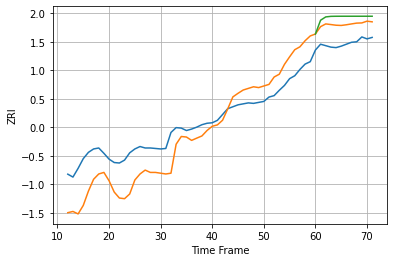

30350 50.468288503311065 39.01682231439715 53.20048351744899


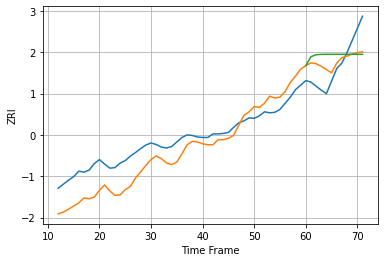

30605 38.36040500187862 38.20591185007736 51.36709112117205


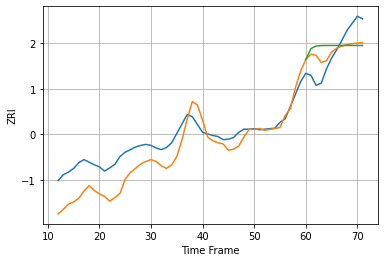

30606 38.21777396069523 34.93642712632425 45.867890450670316


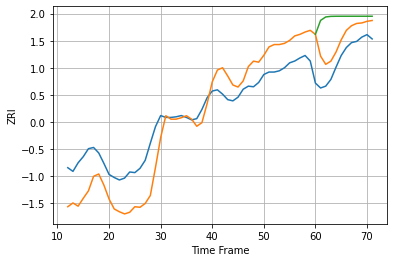

31401 43.857480613112905 37.36000301837889 72.06595666818436


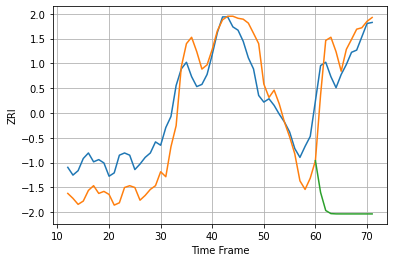

32204 26.119379882428117 24.35243579957051 136.92122063353554


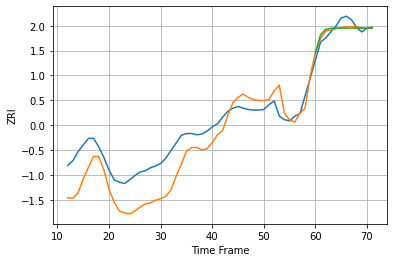

32205 39.05478585540294 9.494517625383589 10.984128471920032


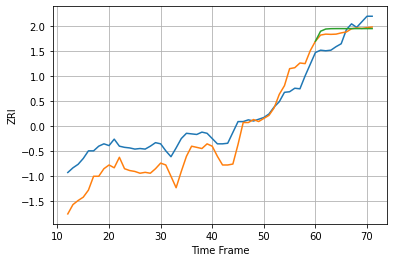

32207 38.61533104760902 18.96709066414889 23.938998661557434


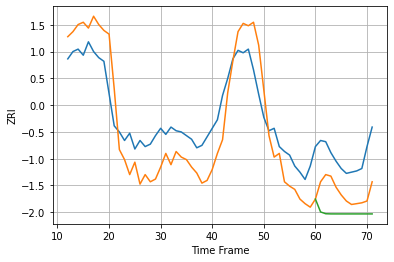

32209 25.876348982915236 31.336846693175026 47.99669106363608


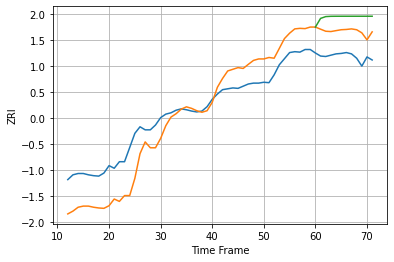

32224 55.79879197635366 58.59314615361754 90.046834093997


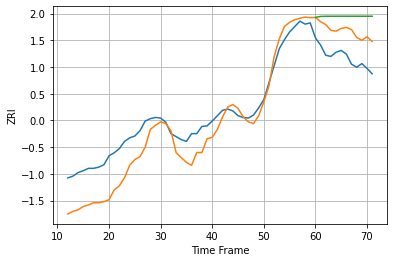

32225 37.209570156339566 45.52724107460323 70.64725738248707


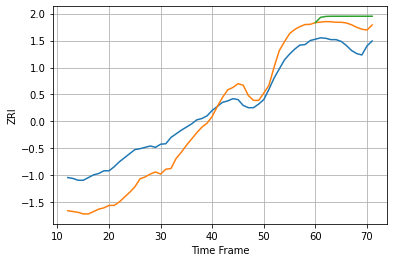

32246 55.335943072141234 44.48466004736607 61.80890191623062


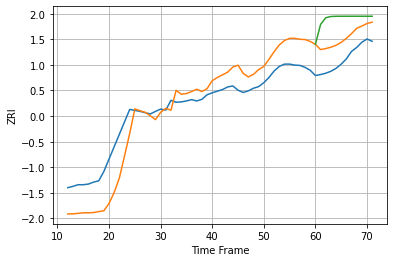

32250 68.90672205930278 67.24329375287893 126.55103401436776


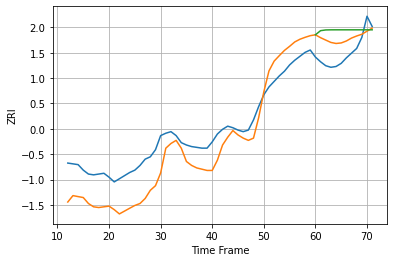

32256 31.680825448944862 23.830195204986577 33.99369154077561


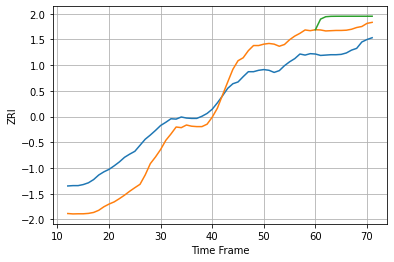

32701 71.12165547807042 61.52674719122225 92.97912652390877


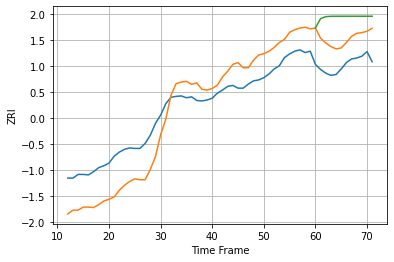

32703 56.7750077313631 59.14070230491665 104.67067629231842


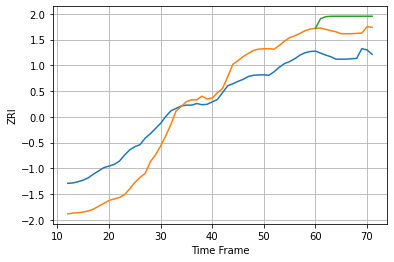

32714 62.51787060070931 61.13981301482593 94.8723622430346


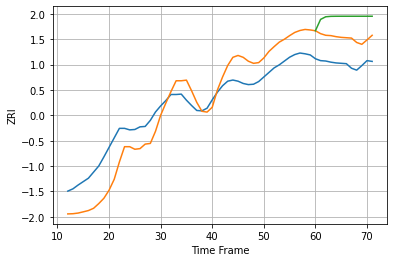

32771 60.459408939270645 68.51095333115113 120.56063274364413


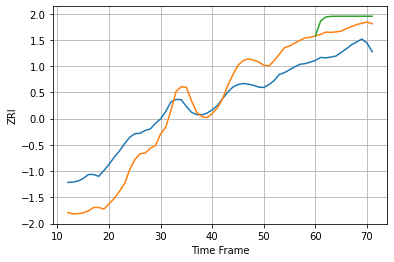

32792 67.58347169262119 61.60713165004448 91.70647442235207


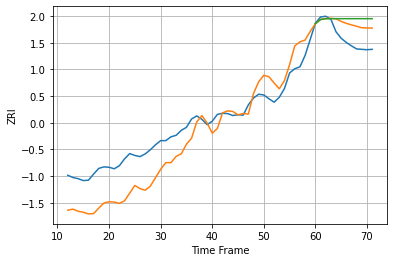

32801 65.44444537392262 42.801473842733316 57.015311249221654


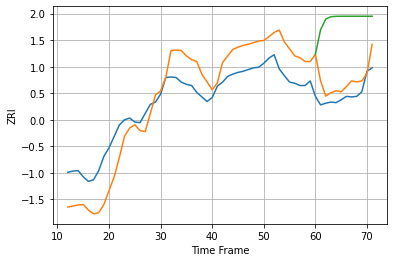

32803 46.70100031682925 31.697921137197476 130.88191306213642


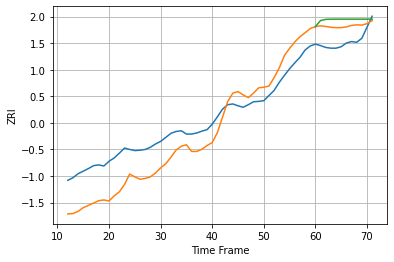

32810 67.1220163782803 45.79903725969698 61.99693619512817


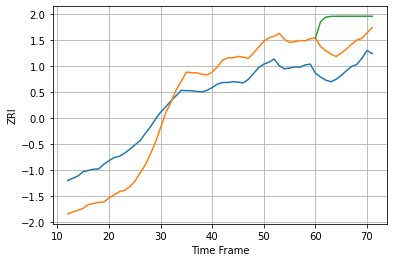

32811 68.75635906341586 65.1153873096042 132.53804182268382


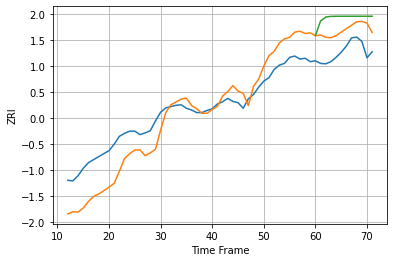

32812 52.855629830092 52.97871945975324 82.13652370209054


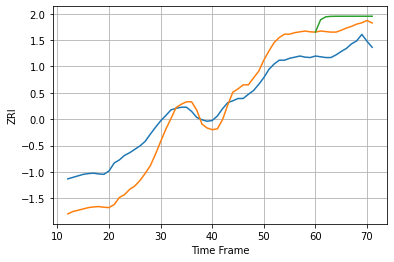

32822 65.23207786280803 57.42658061196793 84.64244175782031


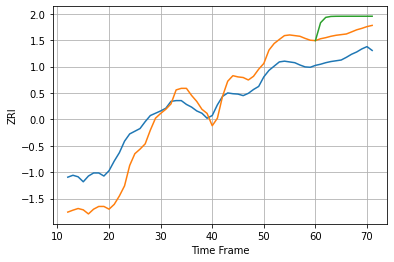

32825 62.8631705446704 62.20816547282234 100.85980714354274


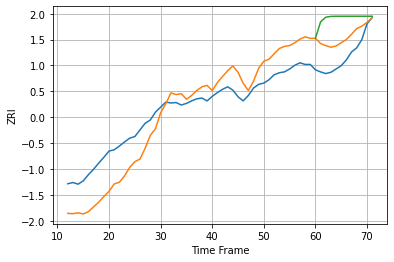

32835 57.41266352257077 51.883599660403846 98.05006391498885


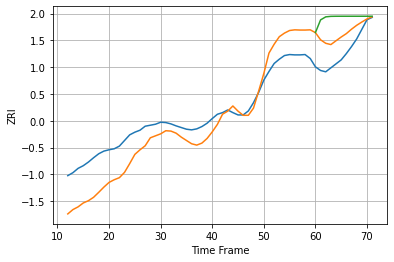

32837 68.5667647486891 64.318979731798 112.04225840389269


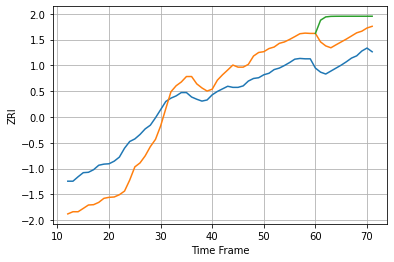

32839 68.04190540789509 67.45474844264245 120.87411688049914


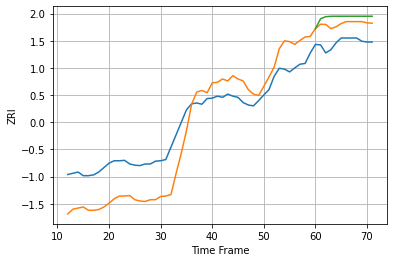

32935 70.45276583939857 46.92264295582634 63.610015434289444


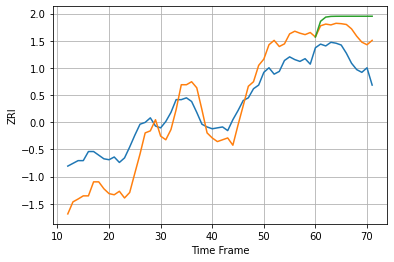

33009 28.163029019096022 29.494517912048128 45.579525356454646


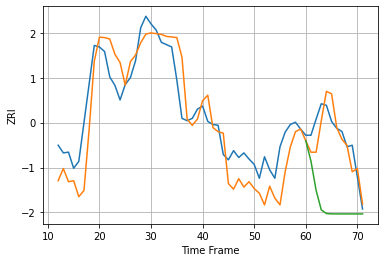

33010 35.84881081307304 22.315430206976025 93.61380430122324


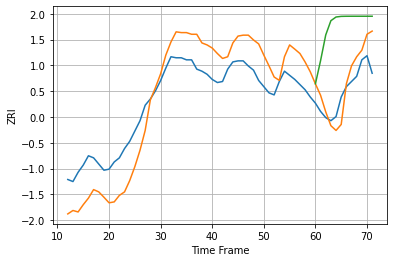

33020 27.85598081740753 18.992876430461894 66.06069317132048


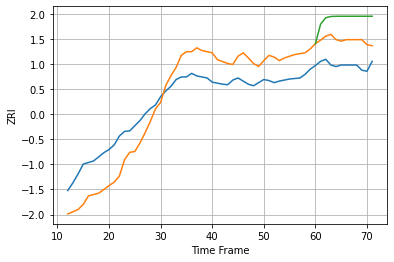

33024 48.967006785610806 48.23441700754236 89.68251767580945


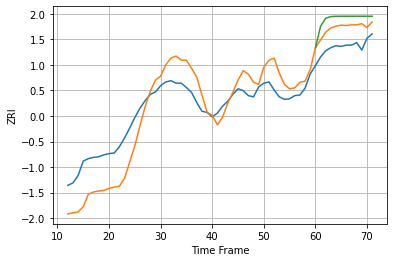

33025 37.88924670777296 30.18141873408662 44.822957427922056


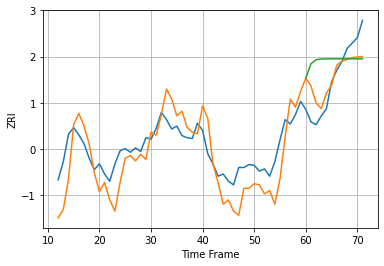

33062 33.127938335755964 28.373900378634755 52.287991676816645


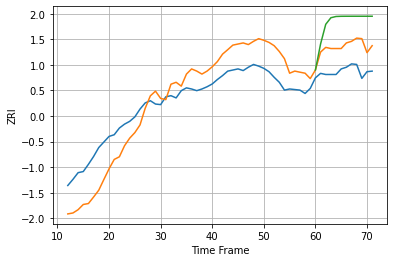

33065 43.27364472524945 44.48992517689105 89.53265790092605


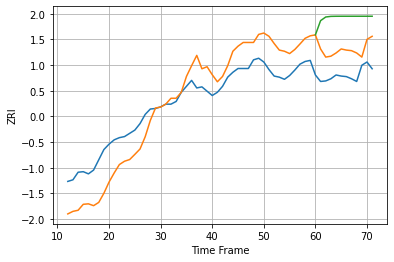

33066 46.37381675480555 50.41516216325219 106.02867166574096


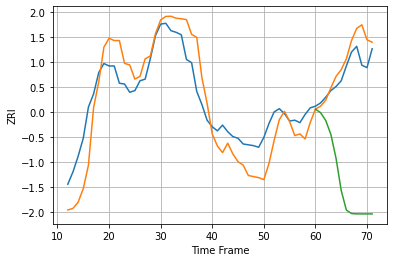

33125 32.11219375493283 19.917250588597472 143.0225974920423


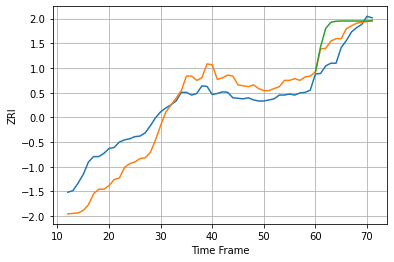

33126 40.480188161393734 25.770876110865057 44.24926331741787


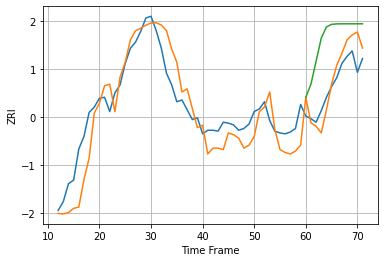

33127 25.41199001704695 19.380555042792814 55.37614406937227


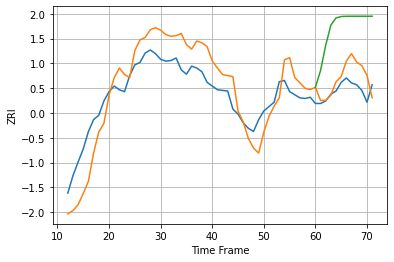

33130 38.76442306846908 27.629631403740873 103.13582879277989


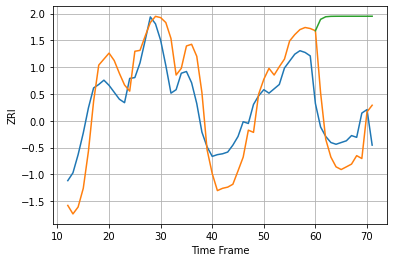

33131 33.06975571695019 38.624357565656226 132.7262607548205


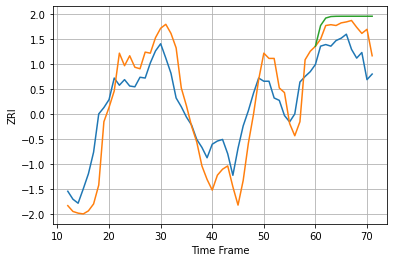

33132 35.939726289983184 29.934107135408265 44.72540494189252


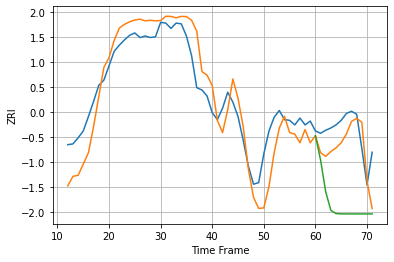

33133 31.782701019560267 31.982165184034127 98.65030491956195


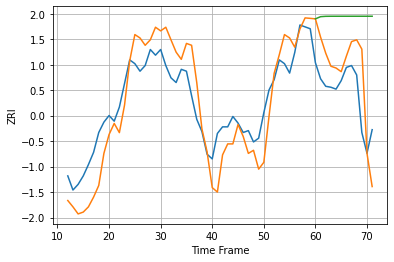

33134 29.646679501540444 40.883501232117226 85.93600096747926


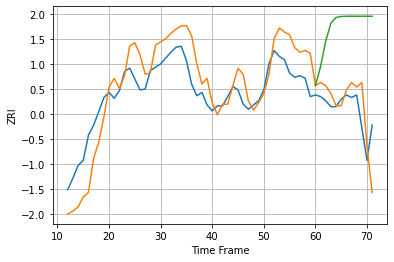

33135 30.32356387453321 30.394849226868057 103.4438157868027


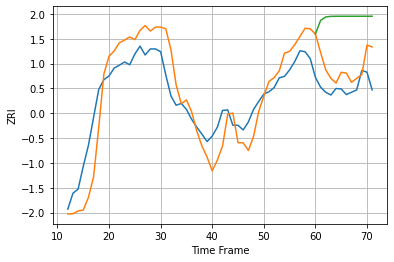

33137 53.5602677626802 53.544772630619114 148.67077823680745


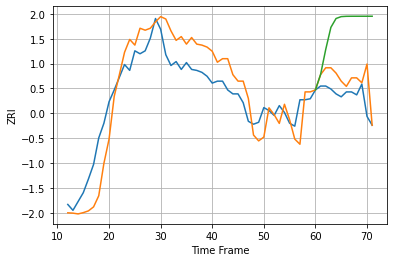

33138 24.836586781178678 20.542373101325936 73.16665063490612


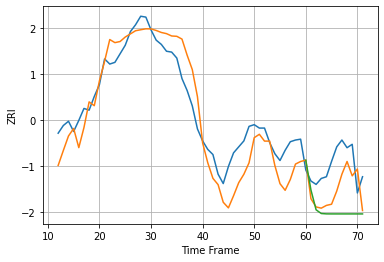

33139 26.63589116988852 34.619839280260514 55.770969757256985


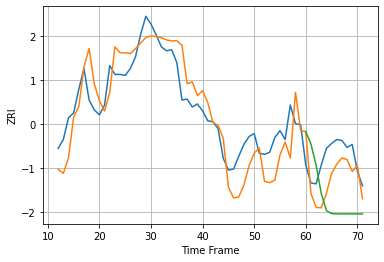

33140 25.318241197178423 27.013305583583865 55.056824945616896


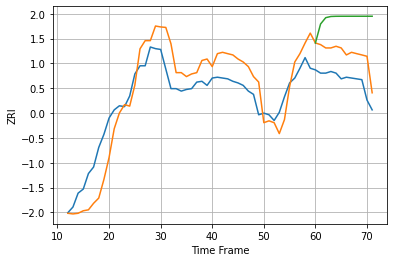

33141 29.098847599294782 33.5749345590805 77.19327369051784


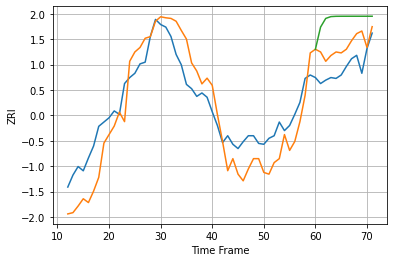

33142 31.38887655972536 27.716406247698707 57.7236835074955


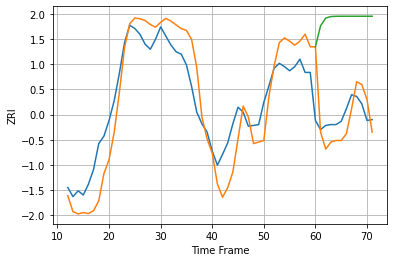

33145 32.914288391172505 32.94863208315613 116.97441016501168


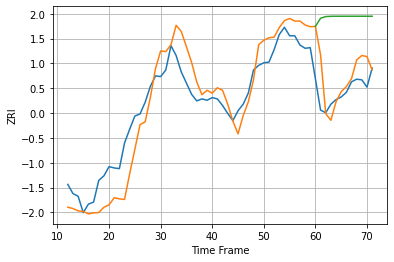

33147 34.65136483120471 39.34618120323022 114.00494272589363


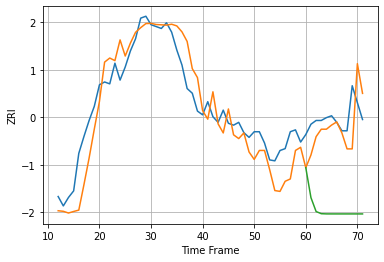

33150 25.359613482396373 29.37443084662123 98.3297283290494


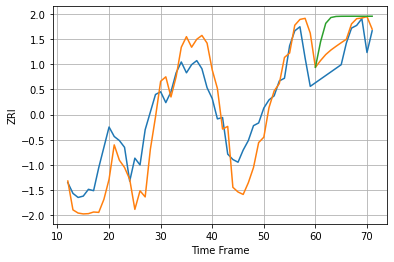

33157 21.885907880520513 13.192908677786075 25.937961038991713


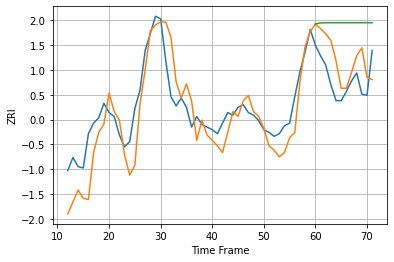

33160 18.81303518384029 21.41527491451967 44.374198084993935


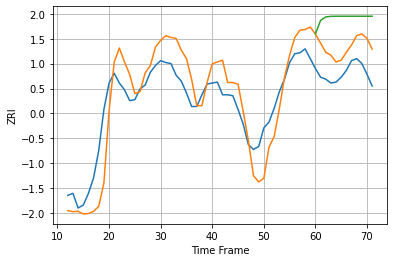

33161 26.698572162938223 28.319273492600807 57.59719048802464


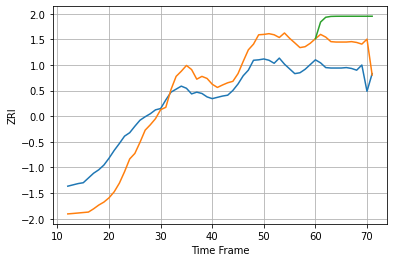

33178 56.447059125330476 65.34768137663934 120.20554401463586


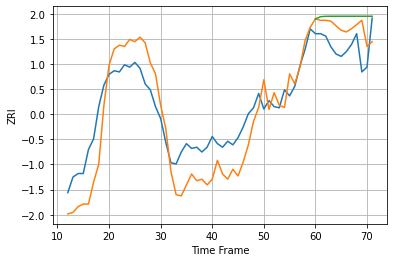

33180 23.988800826719878 20.4246049759562 27.455737420264228


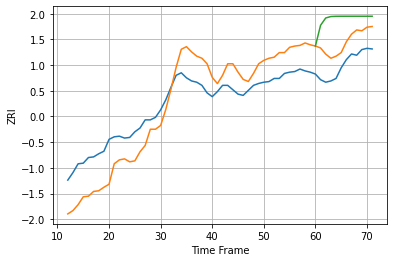

33186 40.721826709585855 37.014572895613455 74.99212091006234


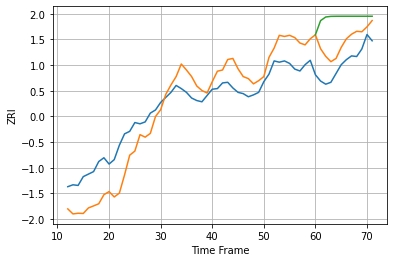

33196 38.36696176716196 37.5073232798803 75.18165752575987


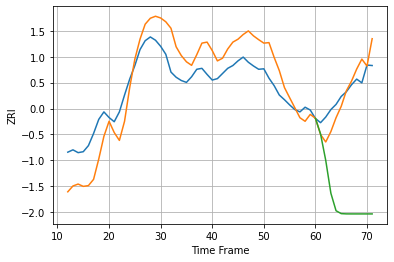

33301 54.81088626420193 33.30773744795936 234.83508044143142


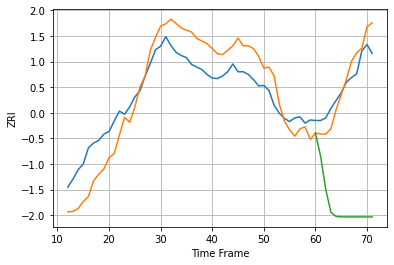

33304 48.42316215092211 30.577116274150242 238.95263939653736


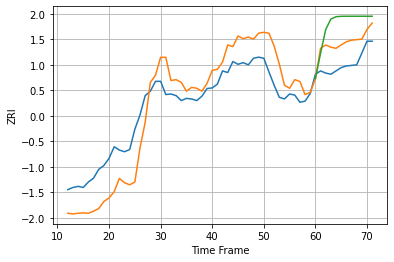

33305 47.23642079770383 39.262802224644155 75.52578696392482


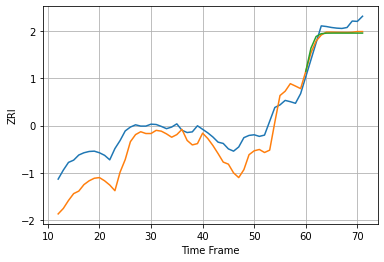

33308 66.9958691858579 24.442190897042227 28.186971062024604


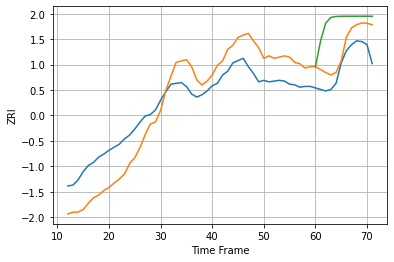

33311 33.80683251979418 25.682751854223746 60.761198337242206


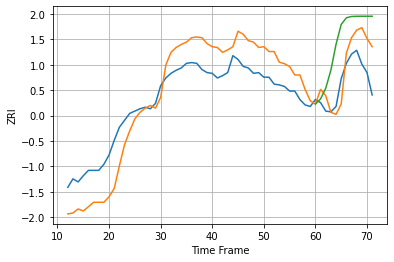

33312 34.063281929275206 30.76014318838892 59.76636366479308


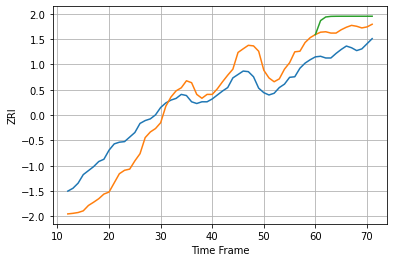

33313 40.58733511273041 37.85430203330249 57.98015654261113


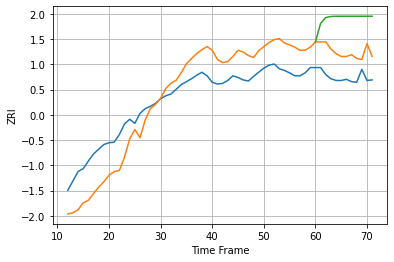

33324 43.103437059792434 45.00722507568663 100.26795055379428


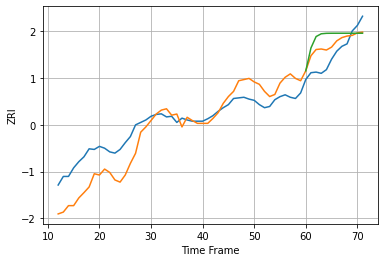

33334 32.77110738312954 23.83325759511723 37.836319033093865


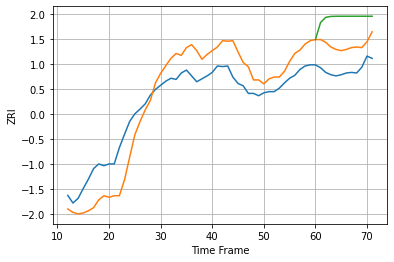

33401 41.70793112305951 42.963322942455704 88.08871328140073


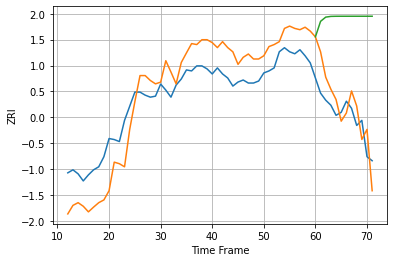

33404 26.925162630744584 24.505118919212524 98.99192279092206


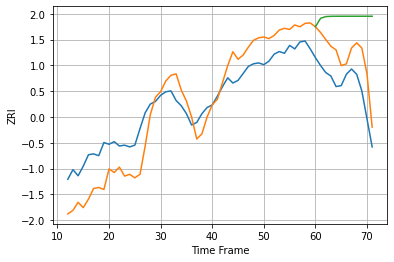

33407 28.73234478997049 35.4743905666082 82.38166440555914


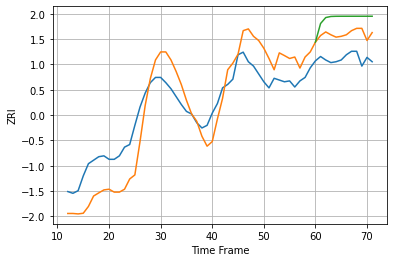

33413 30.43194717471653 28.553980220997886 46.30904512934284


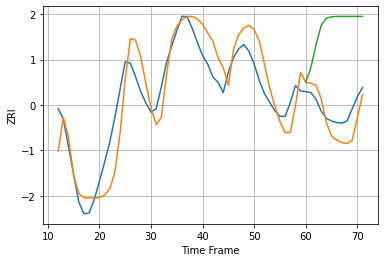

33414 47.34559387381661 32.800050758056706 163.74775637823026


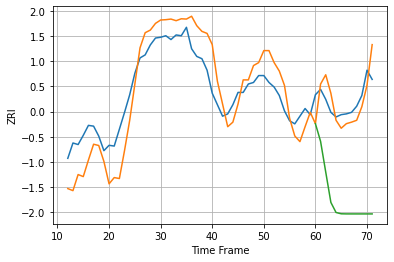

33418 32.7492039719447 23.771536370257305 130.82010952486326


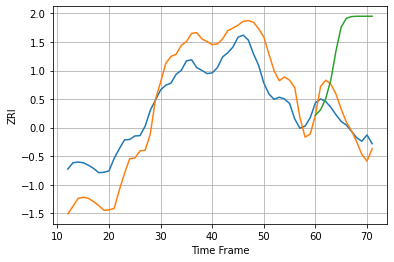

33432 81.5771445377874 43.23887145361335 258.20170988794604


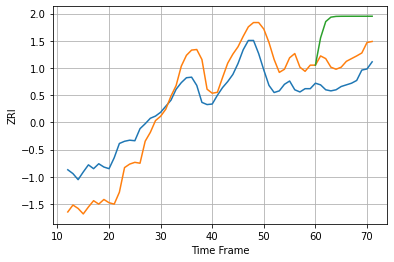

33433 50.19036806852277 42.98206842707702 110.52488087857638


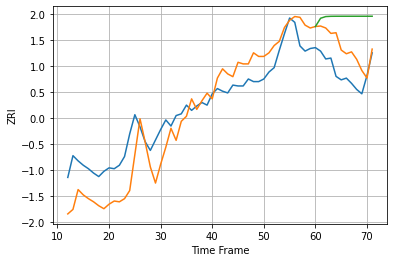

33435 29.935498155734827 30.54080408578719 63.98196686295819


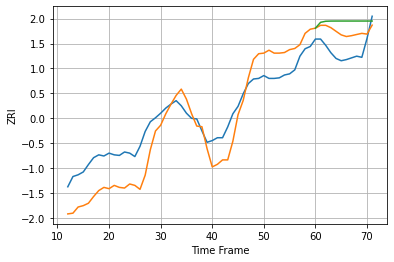

33436 44.553347355229235 35.46428959381146 52.29810843925696


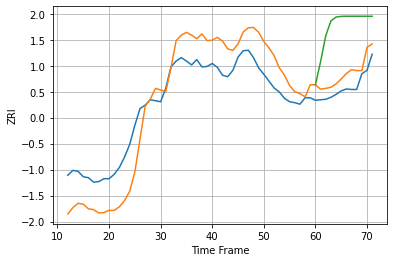

33444 56.360745064452175 29.16659245190572 127.35203800706243


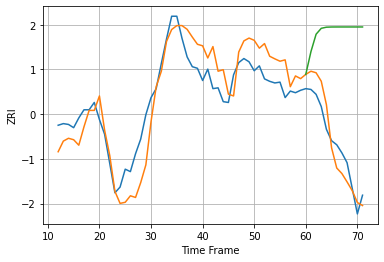

33460 28.902137327614746 22.08758390554348 147.24223338491785


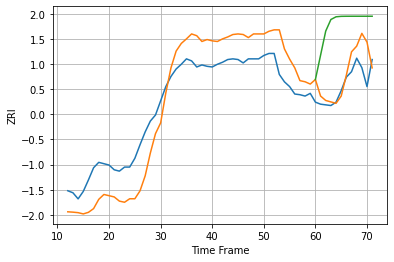

33461 40.30342253182013 28.338034885483708 92.10360990792873


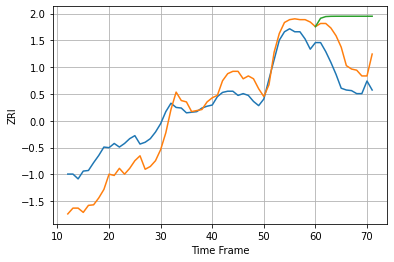

33510 38.149568973810304 45.64305257113782 102.36738977661595


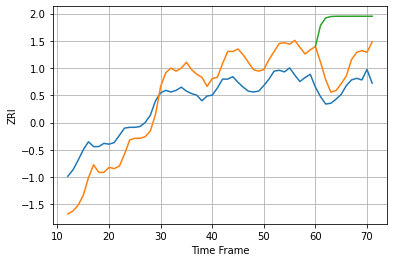

33511 31.624315600414146 31.676486189082244 87.11964091671169


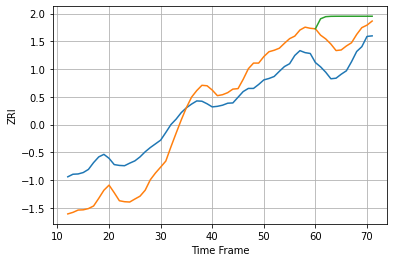

33602 95.23452283125806 89.65822449005042 162.6986776002378


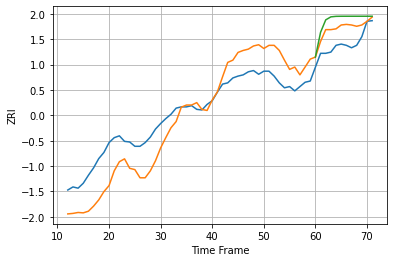

33604 40.10727245792152 27.38849996197544 41.046143040845955


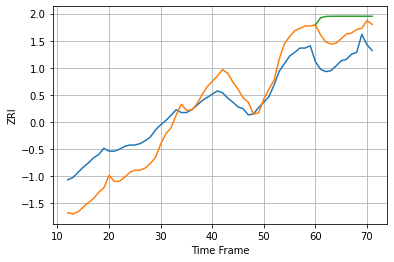

33606 49.27926753582721 55.04108987167253 89.67127667627362


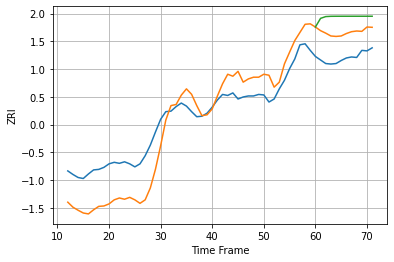

33607 51.56071721943114 51.177150381067285 80.07818532458364


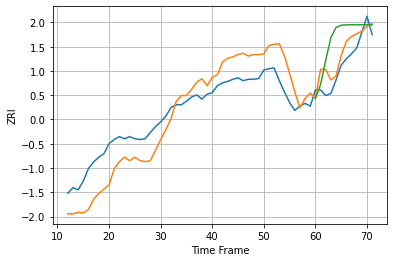

33612 33.32734041494857 20.39502907654805 43.8680116333038


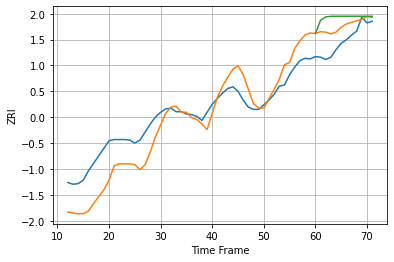

33613 37.950651942687486 29.941850418577207 45.67270433139108


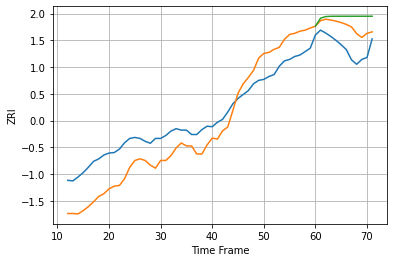

33615 51.825843542408094 42.9598873776206 64.03161855026082


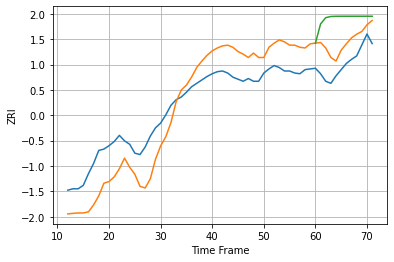

33617 39.23071101133559 32.92637416290165 67.38399492679449


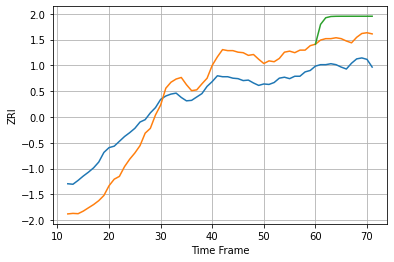

33626 52.1673081878077 53.55713042372447 93.63346617226692


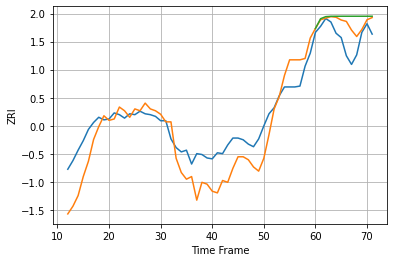

33634 27.272738473762963 20.122579356711604 27.61250295163799


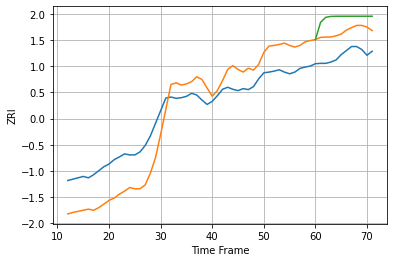

33701 79.61072734265916 69.73347162180029 110.92442716022975


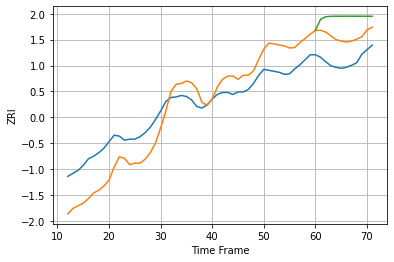

33702 47.7012147472969 49.40261781636273 85.985019139671


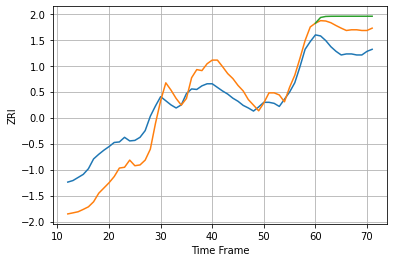

33705 44.036333320770275 43.308563366867354 63.67064321141919


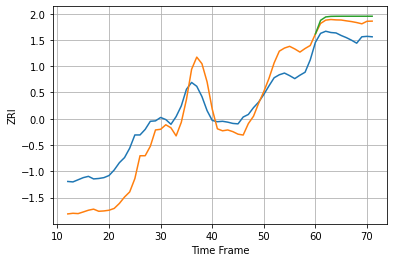

33706 58.087719232033365 34.265316523961985 44.672808025883675


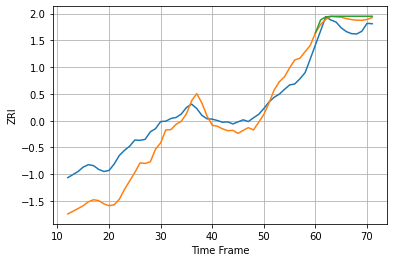

33708 67.18183844656964 27.65354983979494 34.07552519953438


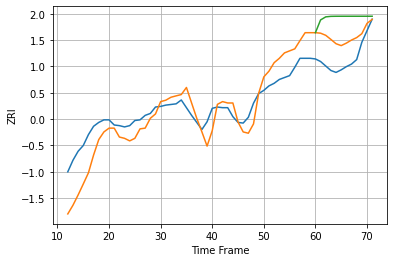

33712 30.576590410832747 36.43697425296332 65.83978258744087


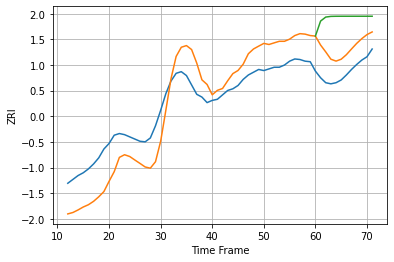

33716 47.39683360563656 44.552172076757934 97.78647461326028


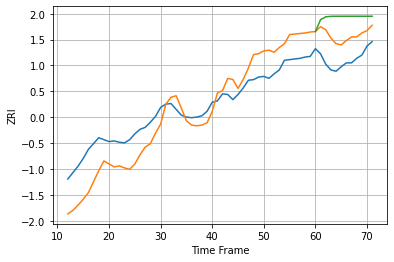

33755 35.722761102602725 37.66949657818584 65.29789048806344


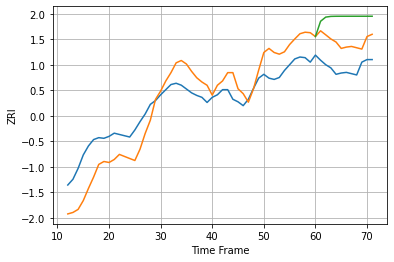

33756 36.184318909110445 40.46225725320868 76.98997870930626


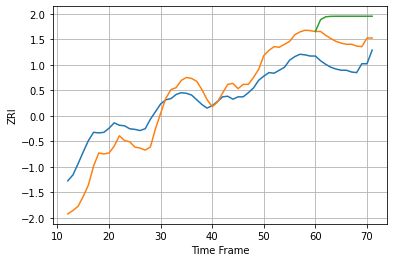

33771 35.91714193816813 43.32851795728462 81.27389363131273


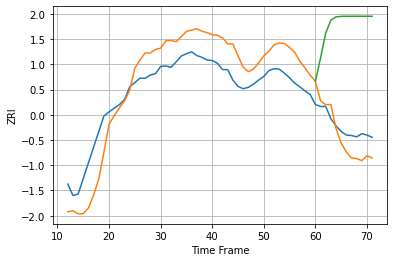

33907 56.42903574995435 38.922186377199914 227.77666507613816


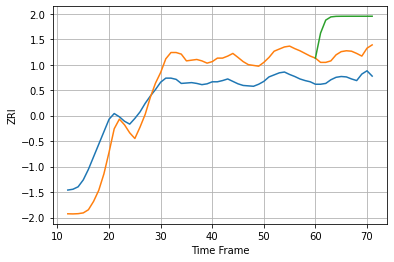

33916 60.909640248301514 59.68548025673111 142.3276116678244


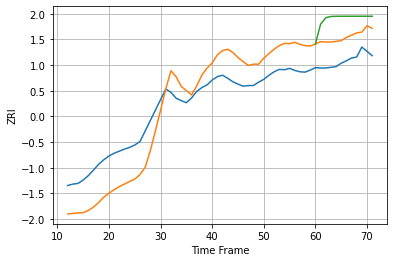

33973 77.3339079793385 70.29028561414844 123.12661228688539


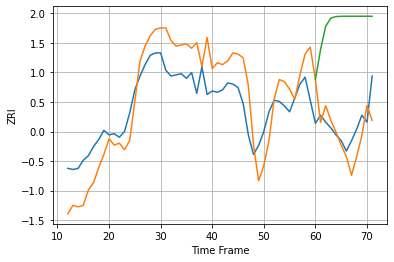

34203 26.24404849031346 20.869247146664048 89.47582560220944


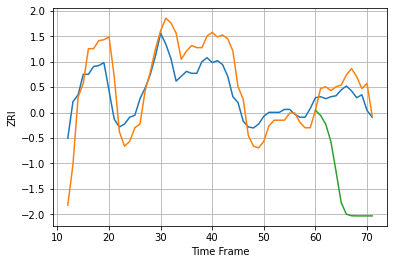

34207 27.105824714335792 14.343896782131008 95.0860103957117


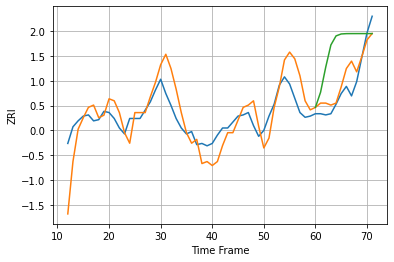

34208 17.55815506276871 11.85508915142253 38.82214173968975


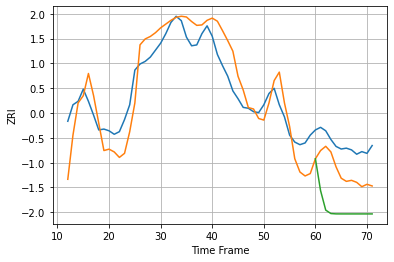

34210 26.497095400829643 32.73469391586913 74.10285459684945


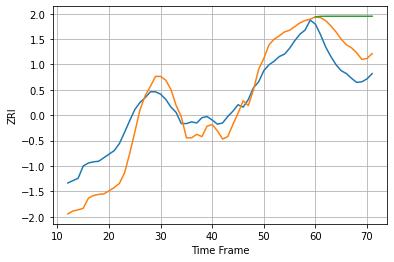

34232 37.47726281421853 43.898064404569546 86.85512166900463


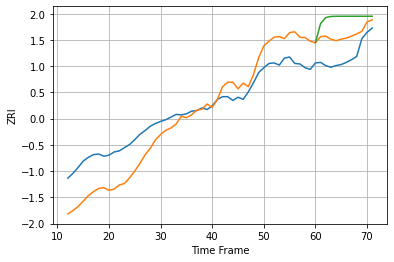

34683 45.70298999331467 41.263496337910425 72.42999596389438


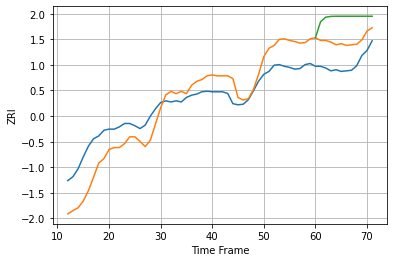

34698 38.49307505815698 42.71104494061234 82.13596507782043


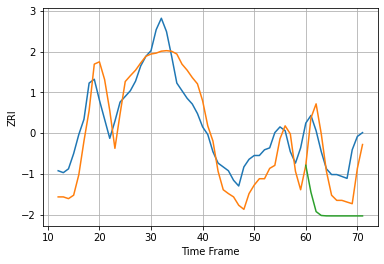

37040 13.081752601387972 14.4735295109711 31.954076303139722


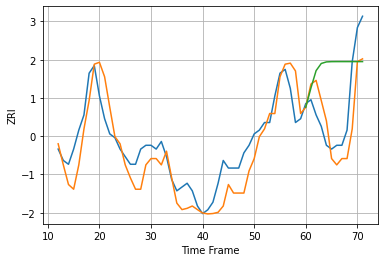

37042 5.941514920822806 8.209080107027207 15.692206366863676


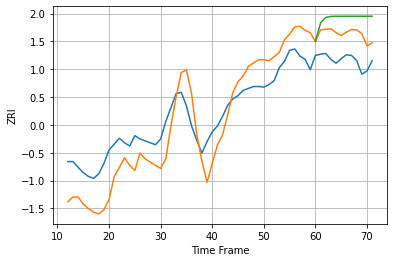

37075 42.12052849194222 41.08150308697545 65.60441884668269


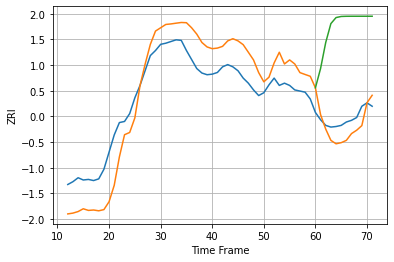

37076 47.23635773143633 26.09607525348699 162.59174000198394


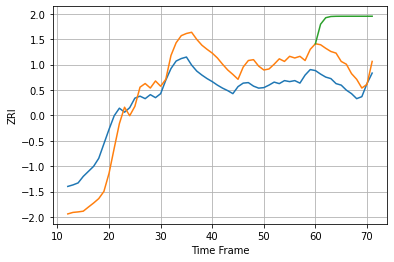

37115 48.85881771693558 45.676269104776 131.70840632867618


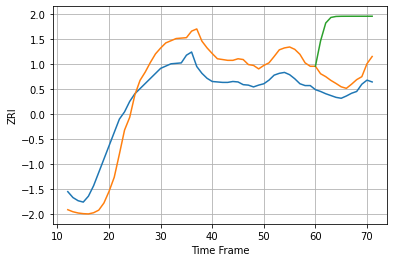

37211 54.581470539647256 34.646863841671475 153.93300353826228


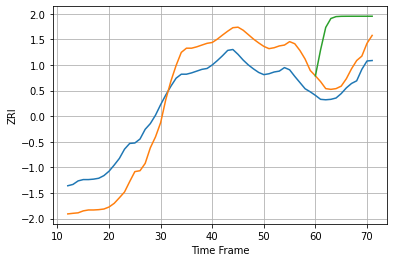

37214 63.19903052012438 35.201071763382686 143.13448499970835


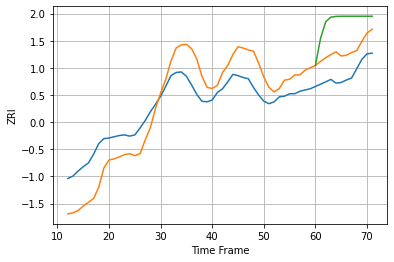

37221 40.6061697464965 38.091936288328874 85.59810431098377


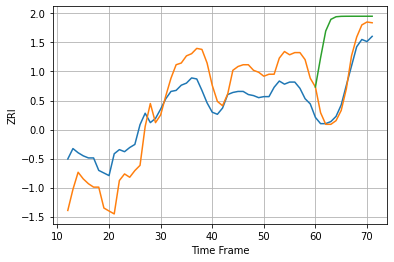

38104 27.040842050550655 12.693977446684118 63.231890398174734


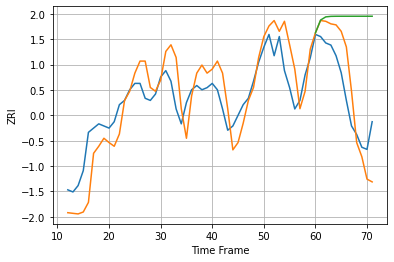

40391 12.24422277820479 15.20615914422794 39.68662412407249


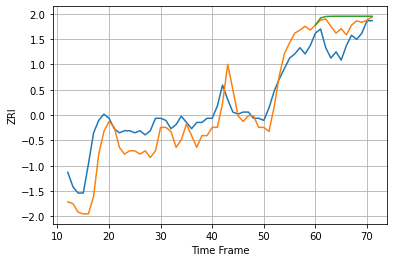

40502 10.365886875000434 8.80990913388829 12.578038929760755


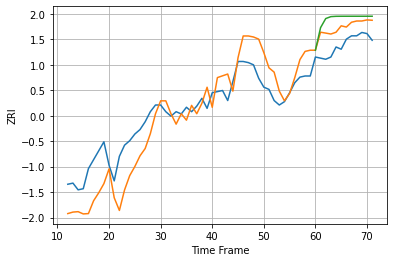

40515 22.36211699898917 16.290826005854964 24.1640736085969


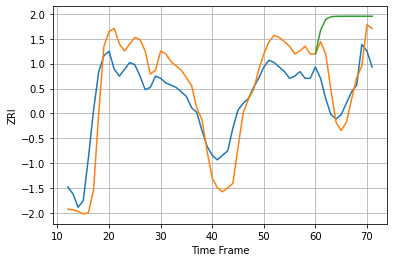

40517 12.593512193624557 11.072234987895602 31.56247604053047


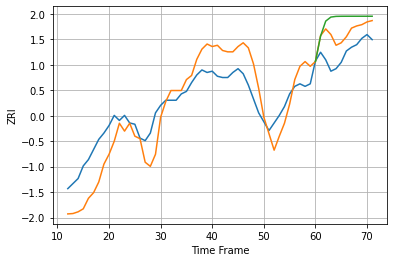

63104 19.378195360541273 16.38743927142197 26.952955031587635


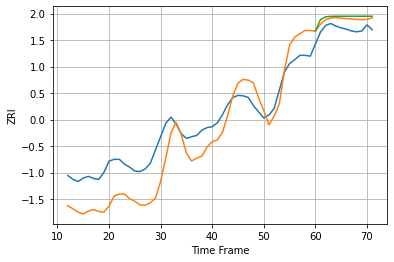

63105 60.861809714785736 22.62050797916796 27.930999351935707


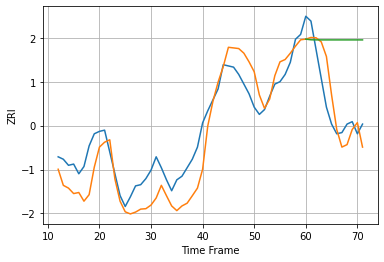

63107 20.098358574015506 20.00083676764204 58.90686022830382


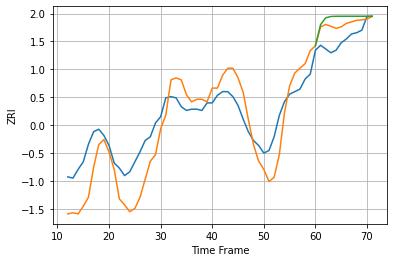

63108 21.237963497893144 12.728515016437878 17.673272996392065


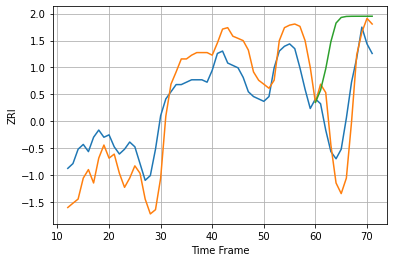

63109 12.616012509392366 12.731927073237458 32.02928802494705


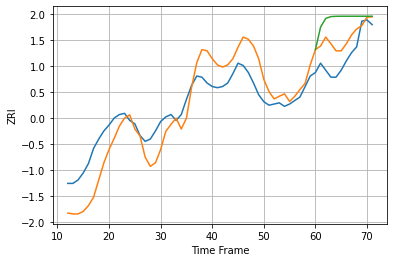

63110 20.073505630482824 17.693085074610604 34.229274200816285


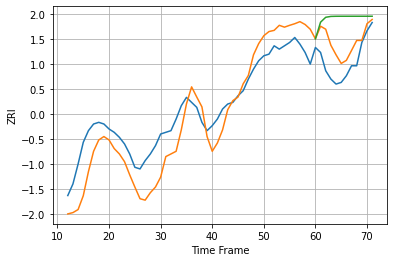

63111 14.784902422755799 13.464315718846395 28.05281618046831


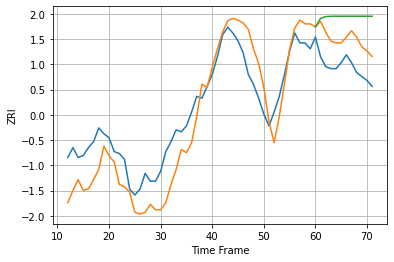

63112 13.964291402846925 14.286949177583113 25.808176171267245


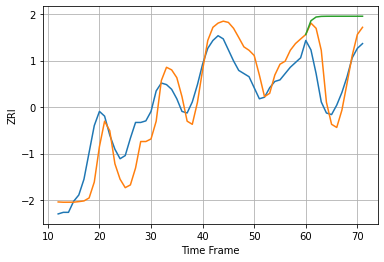

63113 14.801712641733616 15.314340492361081 41.462195892169056


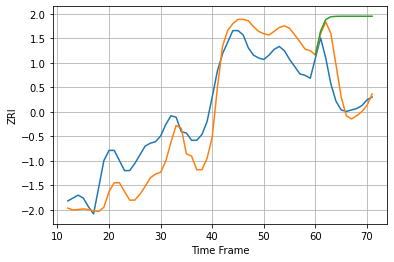

63115 18.37553512635269 14.926682124361717 52.888846960957224


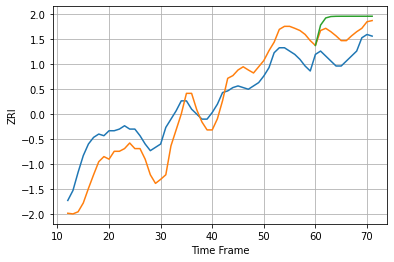

63116 14.346791340384017 12.748774274159613 21.393186543413407


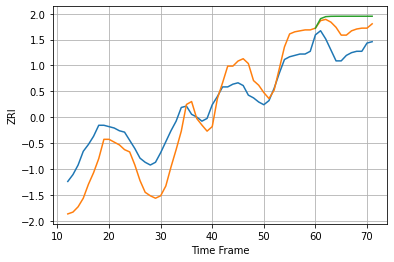

63118 18.067725464108282 15.700848195369504 23.54315756534715


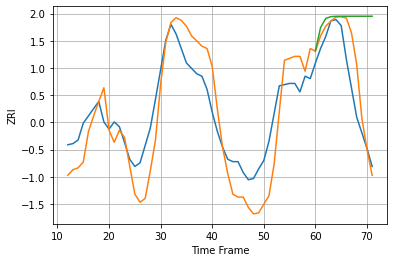

63130 25.070543152921317 21.885434012039035 64.29151997098822


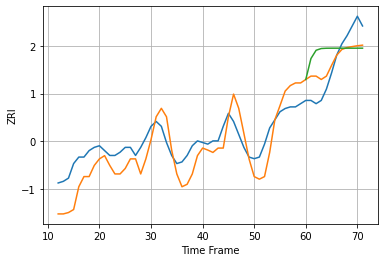

63139 12.872387311506131 11.683577964718962 19.737793477219913


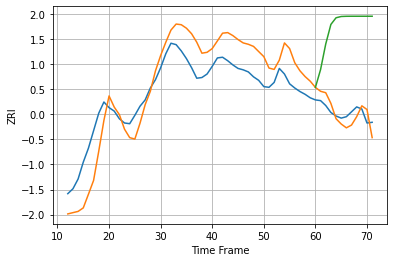

64111 35.82446547260267 15.182690796804321 124.67778587544571


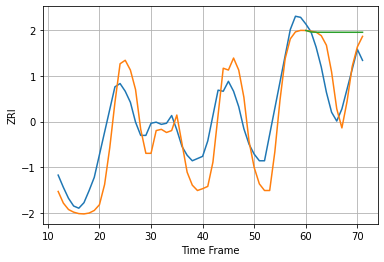

64801 24.173276376091486 20.848598388796667 45.99355133331897


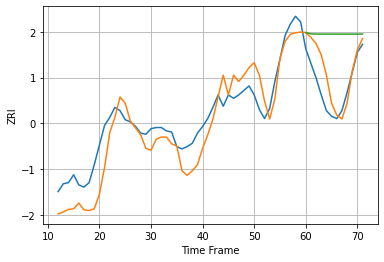

64804 19.23954105539111 18.84507993663693 49.87844192390933


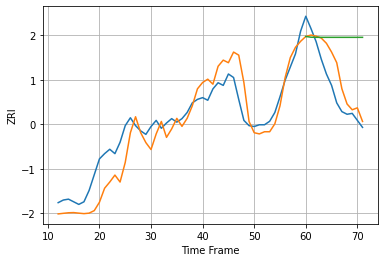

64834 22.354034908458246 24.293840701105374 66.91844751912605


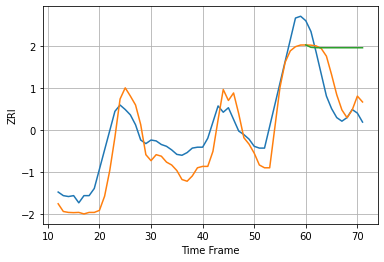

64836 24.180427271506925 23.99343754696029 61.365078104788225


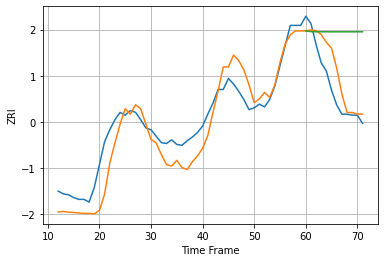

64870 21.68376328538854 23.8322912840833 68.80460530634305


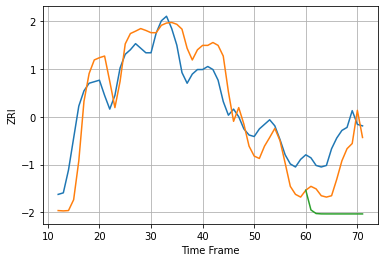

65201 16.3287811650253 20.014634227692323 47.10802699157939


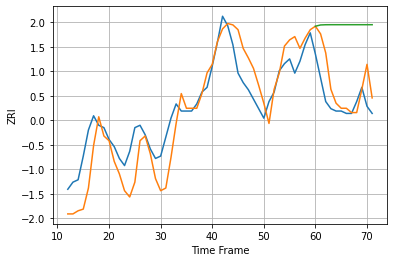

65202 10.884261393128524 10.672559000202325 32.579292150431066


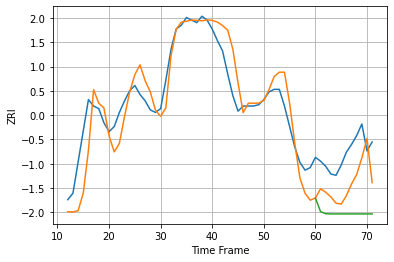

65203 17.54887836107388 26.50410717257608 47.17320705988949


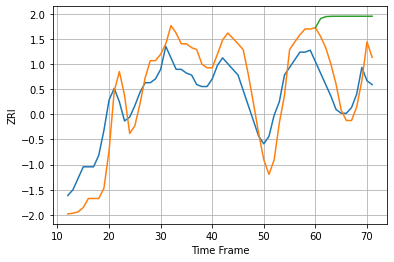

72205 14.425772075280268 13.80306921631175 39.52796213577707


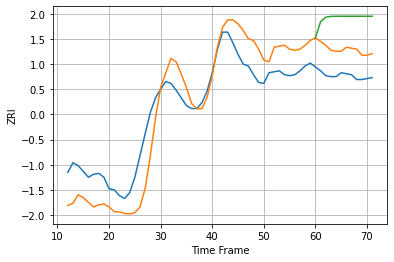

72712 26.853269454924966 27.48170396540994 59.34526053048265


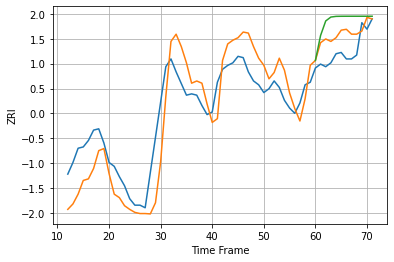

72764 21.686414365158715 15.183645289631832 25.562940055006944


In [14]:
time_train = list(range(SPLIT));
time_test = list(range(SPLIT, len(single_city_series)))

score_dict = {"zip":[], "RMSE_train":[], "RMSE_test":[], "RMSE_pure":[], "forecast":[]};

for zip_num in multi_3:
    test = multi_data[multi_data["zip"] == zip_num];
    city_mean = cities_stats[zip_num]["mean"];
    city_std = cities_stats[zip_num]["std"];
    
    single_city_series = (np.array(test["zri"]) - city_mean)/city_std;
    
    forecast = []
    results = []
    for time in range(len(single_city_series) - WINDOW_SIZE):
        forecast.append(model.predict(single_city_series[time:time + WINDOW_SIZE, np.newaxis, np.newaxis]))

    #print(forecast)

    # forecast = forecast[SPLIT - WINDOW_SIZE:]
    # print(np.array(forecast).shape)
    results = np.array(forecast)[:, -1, 0]
    actual = single_city_series[WINDOW_SIZE:]
    time_actual = range(WINDOW_SIZE, len(single_city_series));

    pure_forecast = list(single_city_series[SPLIT - WINDOW_SIZE: SPLIT]);
    for time in range(SPLIT, len(single_city_series)):
        # print(model.predict(pure_forecast[-WINDOW_SIZE:][np.newaxis]))
        pure_forecast.append(np.array(model.predict(np.array(pure_forecast[-WINDOW_SIZE:])[..., np.newaxis, np.newaxis]))[-1,0])
    pure_forecast = np.array(pure_forecast[WINDOW_SIZE:]);
    
    M_train = mean_squared_error(actual[:-TEST_LENGTH], results[:-TEST_LENGTH])**0.5 * city_std;
    M_test = mean_squared_error(actual[-TEST_LENGTH:], results[-TEST_LENGTH:])**0.5 * city_std;
    M_pure = mean_squared_error(actual[-TEST_LENGTH:], pure_forecast[-TEST_LENGTH:])**0.5 * city_std;
    forecast = list(np.array(pure_forecast[-TEST_LENGTH:]) * city_std + city_mean);
    
    plot_series(time_actual, actual);
    plot_series(time_actual, results);
    plot_series(time_test, pure_forecast);
    plt.show();
    
    score_dict["zip"].append(zip_num);
    score_dict["RMSE_train"].append(M_train);
    score_dict["RMSE_test"].append(M_test);
    score_dict["RMSE_pure"].append(M_pure);
    score_dict["forecast"].append(forecast);
    print(zip_num, M_train, M_test, M_pure)


In [15]:
print(len(score_dict["RMSE_pure"]), sum(score_dict["RMSE_test"])/len(score_dict["RMSE_test"]),
      sum(score_dict["RMSE_pure"])/len(score_dict["RMSE_pure"]));

202 35.91002552558369 80.1254596681859


In [16]:
test = pd.DataFrame(score_dict)
test.to_csv('NN_3_batch.csv', index = False)

In [17]:
# NN_1_summary = pd.read_csv('./NN_1_summary.csv', index_col = 0);


In [18]:
# NN_1_summary[NN_1_summary.index.isin(score_dict["zip"])]["RMSE_pure"].mean()

### Then, we need to tune the hyperparameters...

#### Starting from here, we need a train/validation/test split

#### Wrapping to GridSearchCV in sklearn...

Plan: use the `tf.keras.wrappers.scikit_learn.KerasRegressor` wrapper

https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn/KerasRegressor

In [19]:
# model.save('saved_model/my_model')
# new_model = tf.keras.models.load_model('saved_model/my_model')